In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np
import glob, json

In [2]:
filename_to_type = {
    'taxi.csv': 'csv',
    'temp.csv': 'csv',
    'stock_prices.csv': 'csv',
    'nz_tourist_monthly.json': 'json',
    'eeg_chan20_2500.json': 'json',
    'chi_homicide_monthly.json': 'json',
    'stock_tsla_price.json': 'json',
    'power.csv': 'csv',
    'sine.csv': 'csv',
    'HF_mono_stat.csv': 'csv',
    'gasoline1.csv': 'csv',
    'gasoline2.csv': 'csv',
    'climate_jfk_tmax.json': 'json',
    'climate_lax_awnd.json': 'json',
    'monthly_beer_austria.csv': 'csv',
    'chi_homicide_weekly.json': 'json',
    'climate_sea_prcp.json': 'json',
    'eeg_chan10_2500.json': 'json',
    'stock_bac_volume.json': 'json',
    'usa_flights_weekly.json': 'json',
}

In [3]:
BASE_DIR = './datasets_user_study_1/'

def get_time_series(filename, type):
    if type == 'csv':
        # Get path to the file by searching recursively in the BASE_DIR
        path = glob.glob(BASE_DIR + '**/' + filename, recursive=True)[0]
        # Read the csv file
        df = pd.read_csv(path)
        # Get the value column
        time_series = df['value'].values
    elif type == 'json':
        # Get path to the file by searching recursively in the BASE_DIR
        path = glob.glob(BASE_DIR + '**/' + filename, recursive=True)[0]
        # Read the json file
        with open(path) as f:
            data = json.load(f)
        # Get the value column
        time_series = np.array(data)
    
    # Z-score the time series
    time_series = (time_series - time_series.mean()) / time_series.std()
    return time_series



In [9]:
# Plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

def plot_acf_wrapper(time_series, lags):
    # Plot ACF
    fig, ax = plt.subplots(figsize=(20, 5))
    plot_acf(time_series, lags=lags, ax=ax)
    plt.show()

In [10]:
# Seasonal Decomposition
def plot_seasonal_decomposition(time_series, period):
    decomposition = seasonal_decompose(time_series, model='additive', period=period)
    fig = decomposition.plot()
    plt.show()

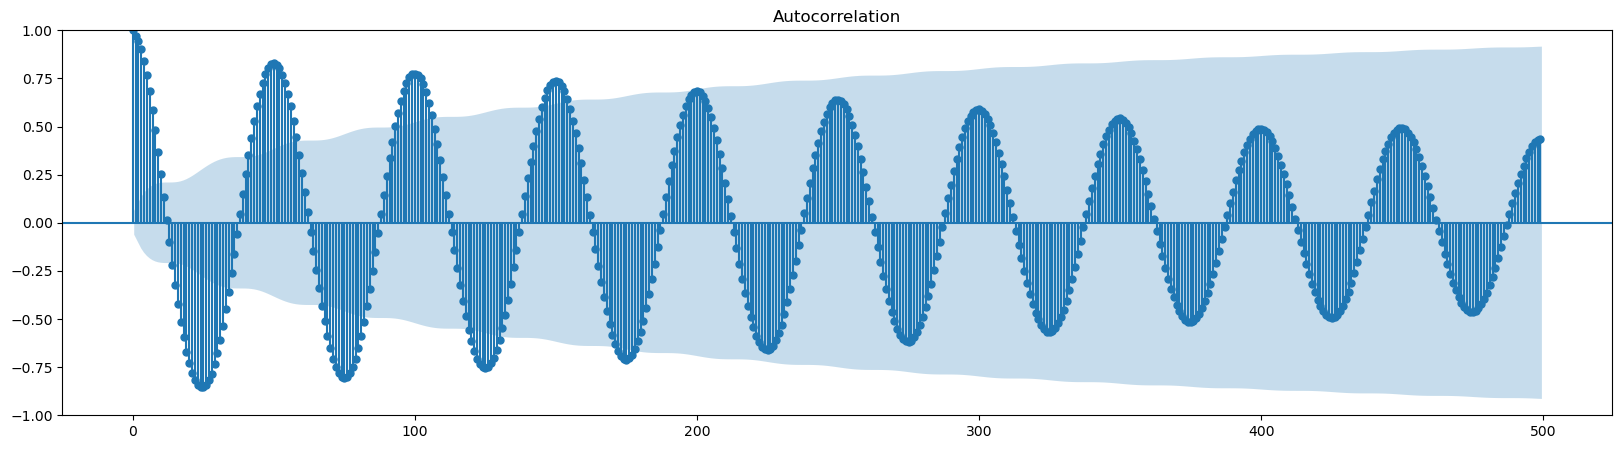

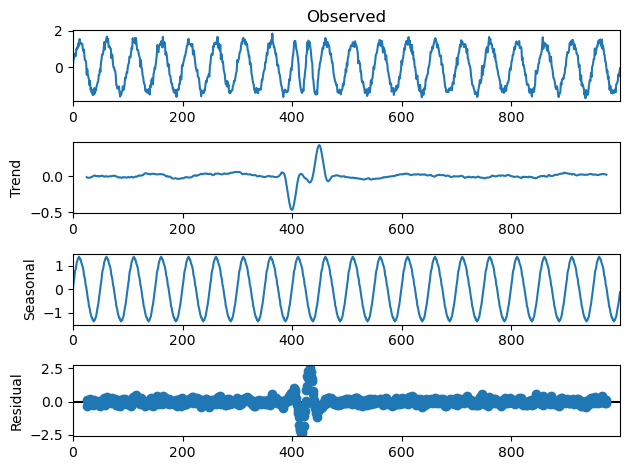

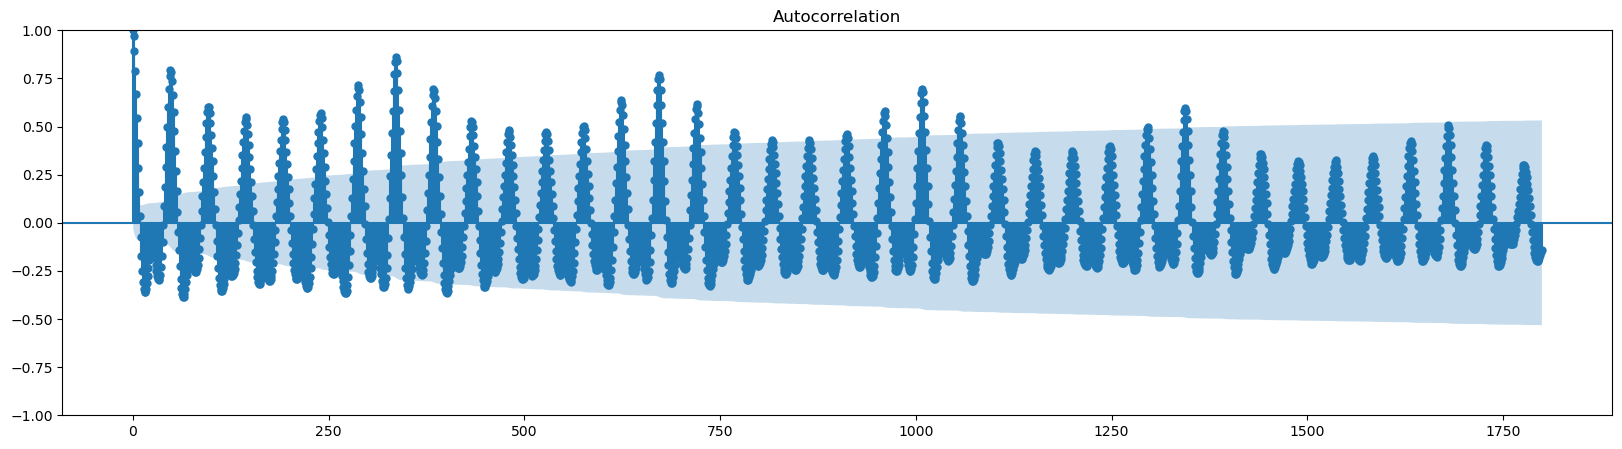

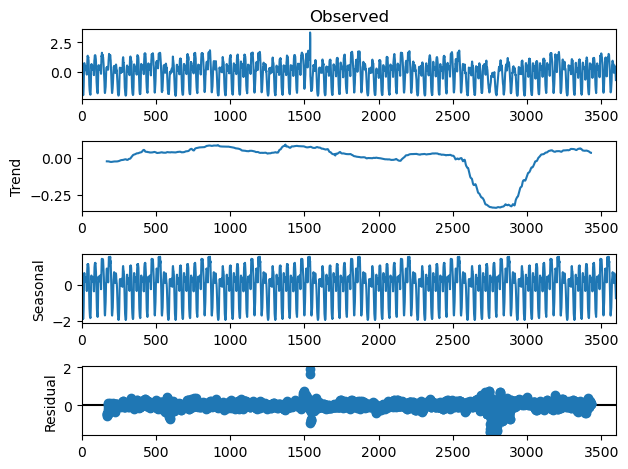

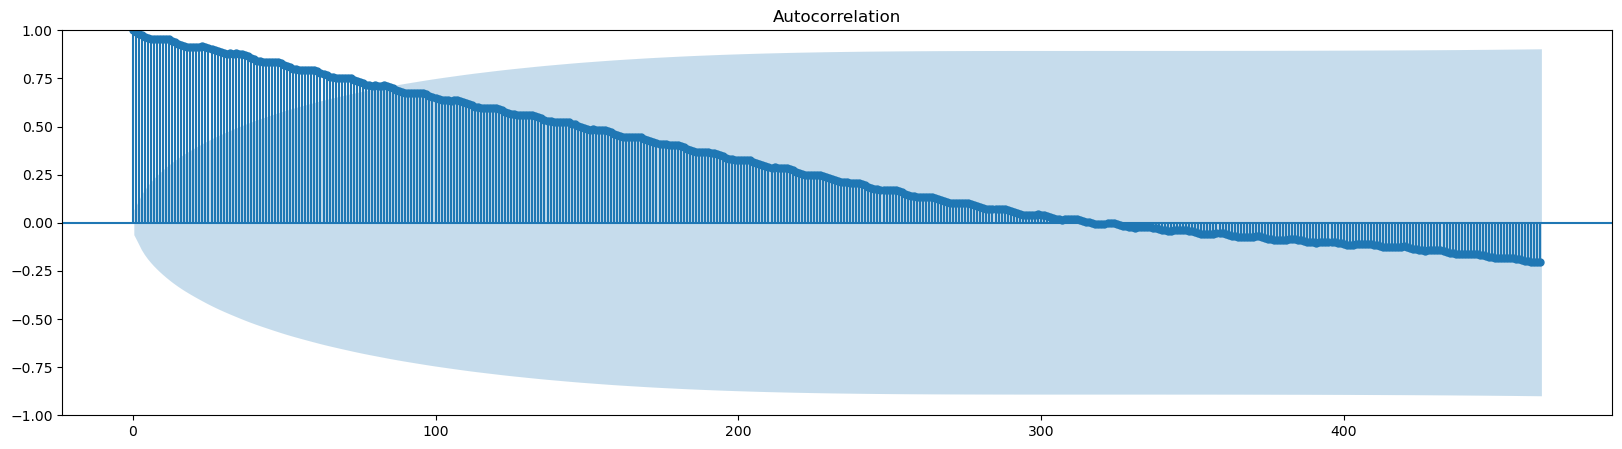

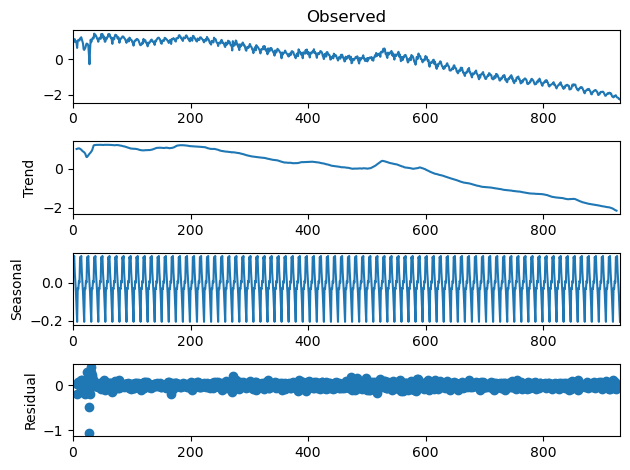

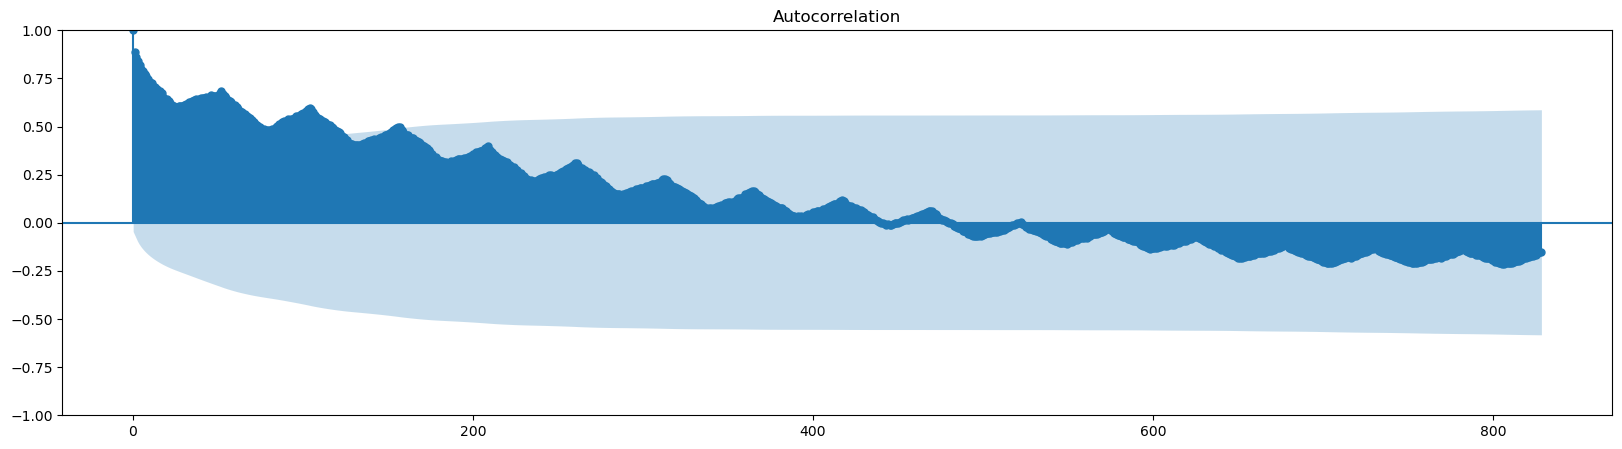

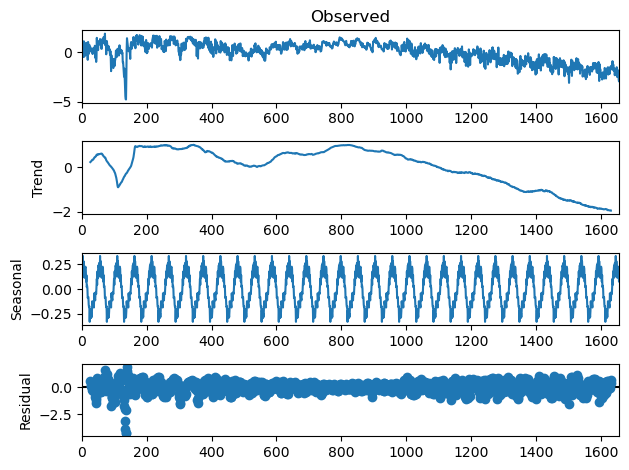

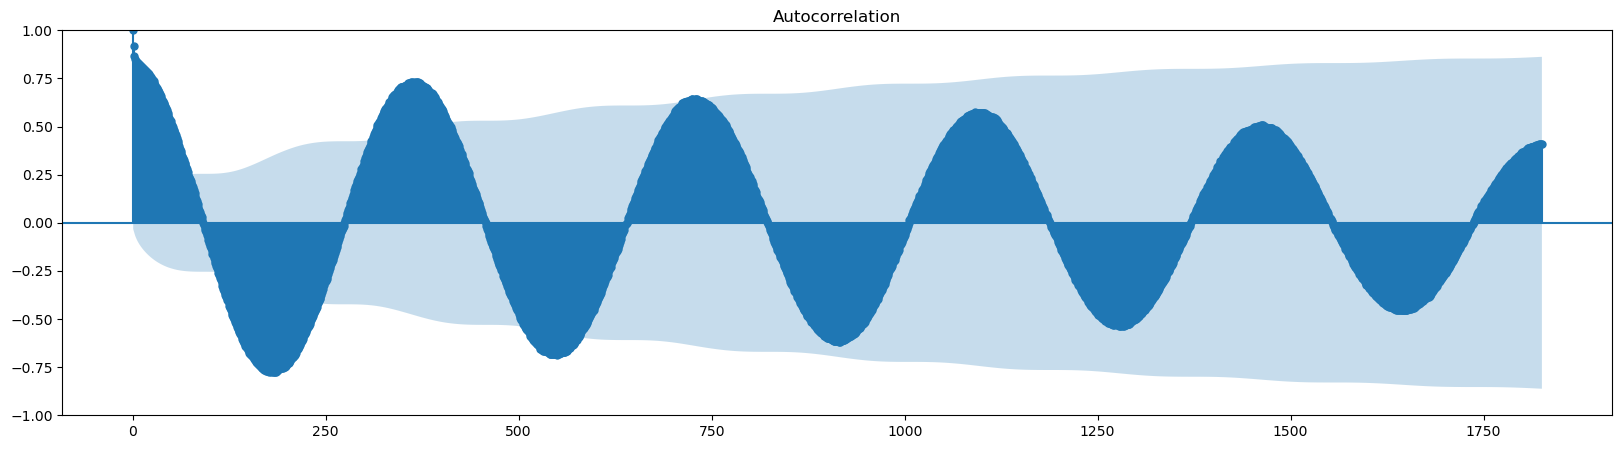

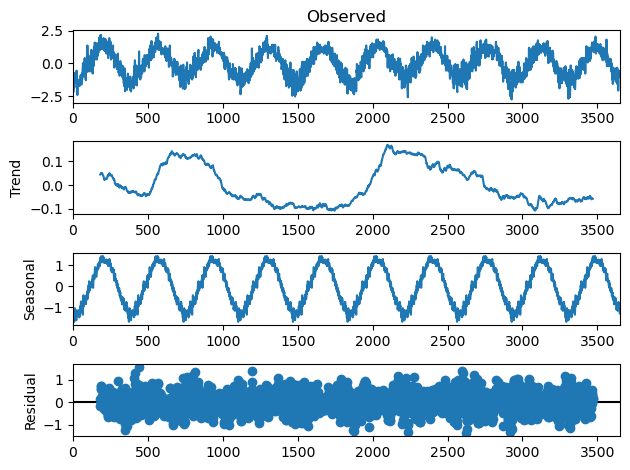

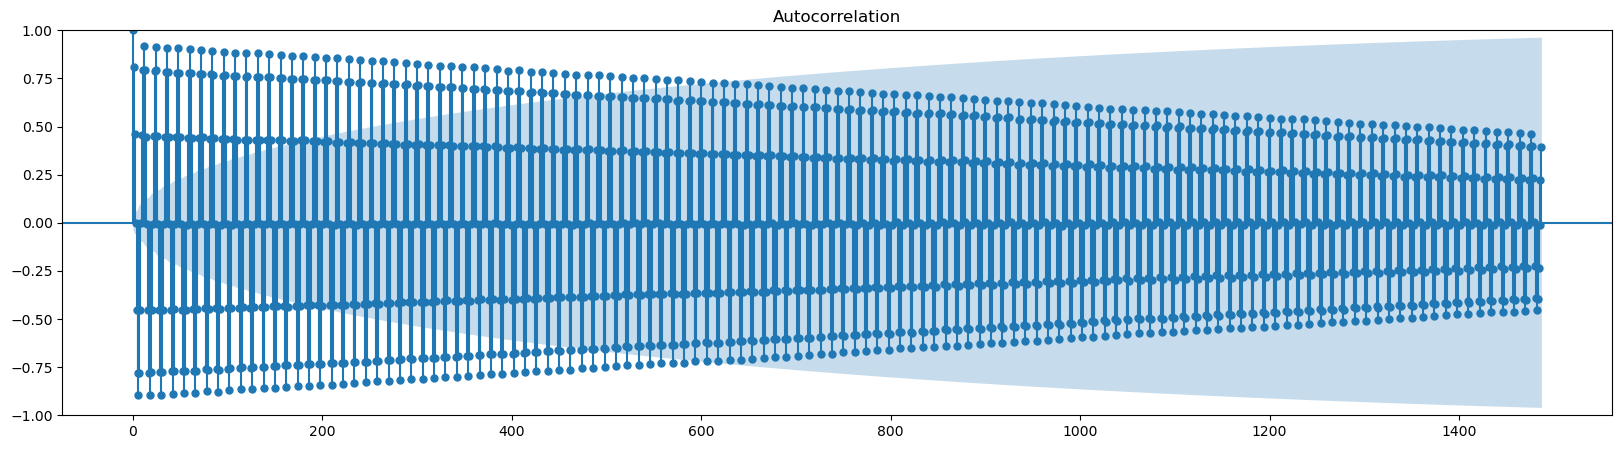

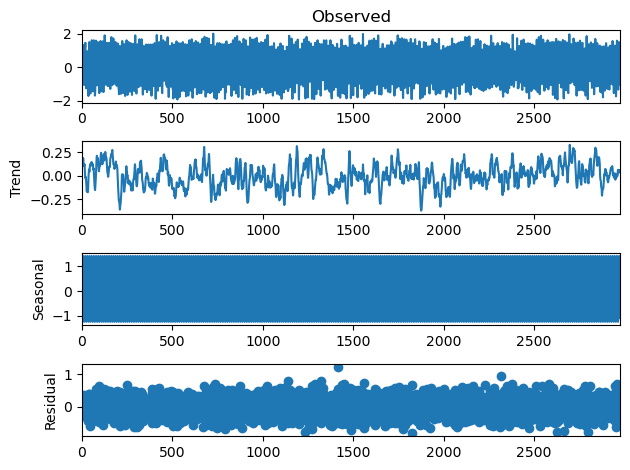

In [11]:
seasonal_datasets = {
    'sine.csv': 50,
    'taxi.csv': 336,
    'gasoline1.csv': 12,
    'gasoline2.csv': 53,
    'climate_jfk_tmax.json': 365,
    'temp.csv': 12,
}

for dataset, period in seasonal_datasets.items():
    time_series = get_time_series(dataset, filename_to_type[dataset])
    plot_acf_wrapper(time_series, int(0.5 * len(time_series)) - 1)
    plot_seasonal_decomposition(time_series, period)

# Siddhi

In [ ]:
import antropy as ant
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stats
import math
import json

for dataset in filename_to_type:
    data = get_time_series(dataset, filename_to_type[dataset])
    print(ant.app_entropy(data))